# Predict Document Classes without neural networks

In [1]:
%%capture

data_dir = "data/kaggle"

# from google.colab import drive
# drive.mount('/content/drive')

# !unzip /content/drive/MyDrive/Kaggle\ Datathon/datathonindoml-2022.zip 
# data_dir = "/content"

## Install and Import required libraries

In [2]:
%%capture
# !pip install Pillow
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install joblib
# !pip install seaborn

In [3]:
from os.path import join, isfile
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
import joblib
import seaborn as sns

## Load dataset

In [4]:
trainDir = join(data_dir, "train/train")
validationDir = join(data_dir, "validation/validation")

labels = pd.read_csv(join(data_dir, "train_labels.csv"))
labels.describe()

,id,label
count,16000.000000,16000.000000
mean,7999.500000,7.512437
std,4618.946489,4.601214
min,0.000000,0.000000
25%,3999.750000,4.000000
50%,7999.500000,8.000000
75%,11999.250000,12.000000
max,15999.000000,15.000000


## Convert the images into matrices after compressing them

In [5]:
shape = {
    # chose this ratio as all the images have shape approximately (1000, 750)
    "image": (100, 75)  
    # "image": (300, 225)
}
number_of_tests = 16000
data = np.zeros((number_of_tests, shape["image"][0], shape["image"][1]))

for id in labels['id']:
  data[id] = np.array(Image.open(join(trainDir, str(id) + ".tif")).resize((shape["image"][1], shape["image"][0])), dtype="uint")

## Dislpay the different classes of images after compression

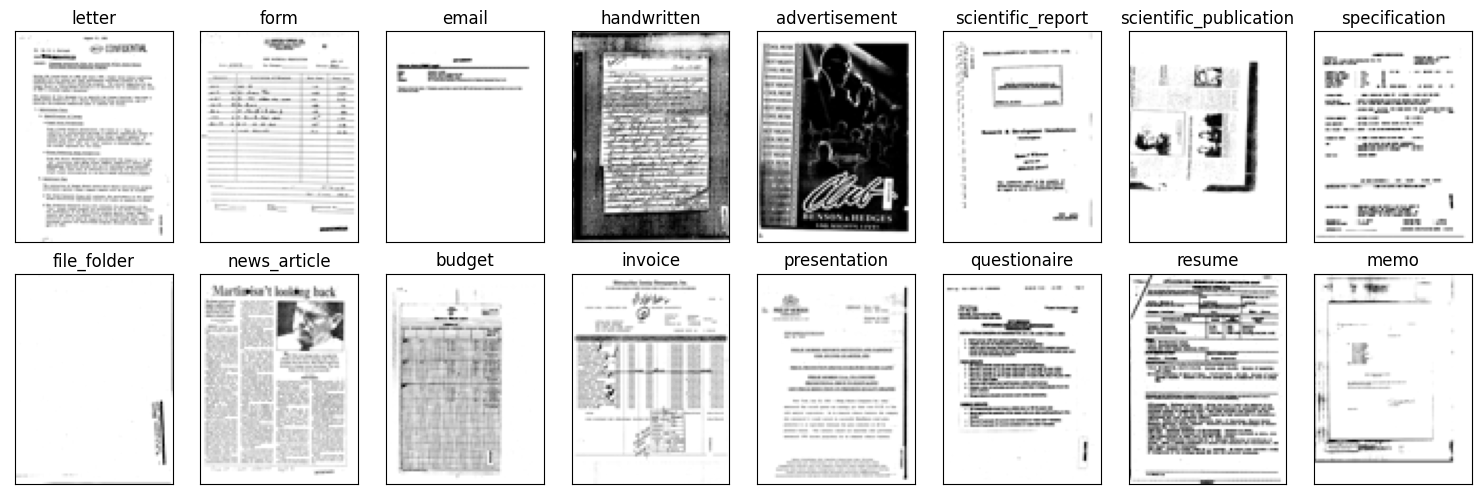

In [6]:
classes = ['letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific_report', 'scientific_publication', 'specification', 'file_folder', 'news_article', 'budget', 'invoice', 'presentation', 'questionaire', 'resume', 'memo']

def findFirst(a, p):
    for i in range(len(a)):
        if (p(a[i])):
            return i
    return -1

fig, ax = plt.subplots(2, 8, figsize=(15, 5))
for i in range(16):
    index = findFirst(labels["label"], lambda x: x == i)
    ax[i // 8][i % 8].imshow(data[index].astype(np.uint8), cmap='gray')
    ax[i // 8][i % 8].set_title(classes[i])
    ax[i // 8][i % 8].get_xaxis().set_visible(False)
    ax[i // 8][i % 8].get_yaxis().set_visible(False)

fig.tight_layout()

## Flatten the data into 1D array to view each pixel as a feature

In [7]:
# Convert the image matrix into linear data (i.e., 2D array into 1D array of features)
data_linear = np.array([x.reshape(np.prod(shape["image"])) for x in data])

# np.savetxt("models/modified_data.csv", data_linear)
print("Data shape: ", data_linear.shape)
data_linear

Data shape:  (16000, 7500)


array([[238., 255., 255., ..., 255., 255., 251.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [247., 247., 247., ...,  80., 197., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 244., 241., 253.]])

## Create a multi-class logistic regression model(pipeline) and train

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X_train, X_test, Y_train, Y_test = train_test_split(data_linear, labels["label"], test_size=0.25)

def linearRegression(X, Y):
    file_name = "models/LinearRegression.sav"
    if isfile(file_name):
        return joblib.load(file_name)

    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("model", LinearRegression()),
    ])
    pipe.fit(X, Y)
    joblib.dump(pipe, file_name)

def logisticRegression(X, Y):
    file_name = "models/LogisticRegression.sav"
    if isfile(file_name):
        return joblib.load(file_name)

    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("model", LogisticRegression(max_iter = 7500)),
    ])
    pipe.fit(X, Y)
    joblib.dump(pipe, file_name)
    
# pipe = linearRegression(X_train, Y_train)
pipe = logisticRegression(X_train, Y_train)

## Model metrics

In [9]:
correct = 0
Y_pred = pipe.predict(X_test)

correct_arr = filter(lambda x: x == 0, Y_pred - Y_test)
for i in correct_arr:
    correct += 1
    
print("Total number of predictions: ", len(Y_pred), ", Correct predictions: ", correct)
print("Balanced Accuracy Score: ", sklearn.metrics.balanced_accuracy_score(Y_test, Y_pred))
print(sklearn.metrics.classification_report(Y_test, Y_pred, target_names=classes))

Total number of predictions:  4000 , Correct predictions:  3372
Balanced Accuracy Score:  0.8424743242250463
                        precision    recall  f1-score   support

                letter       0.82      0.89      0.85       259
                  form       0.79      0.81      0.80       253
                 email       0.95      0.94      0.95       261
           handwritten       0.93      0.87      0.90       238
         advertisement       0.91      0.84      0.87       231
     scientific_report       0.75      0.81      0.78       236
scientific_publication       0.87      0.83      0.85       270
         specification       0.90      0.88      0.89       252
           file_folder       0.77      0.86      0.81       281
          news_article       0.83      0.77      0.80       262
                budget       0.83      0.80      0.81       228
               invoice       0.85      0.82      0.83       246
          presentation       0.75      0.78      0.76     

## Plot the confusion matrix

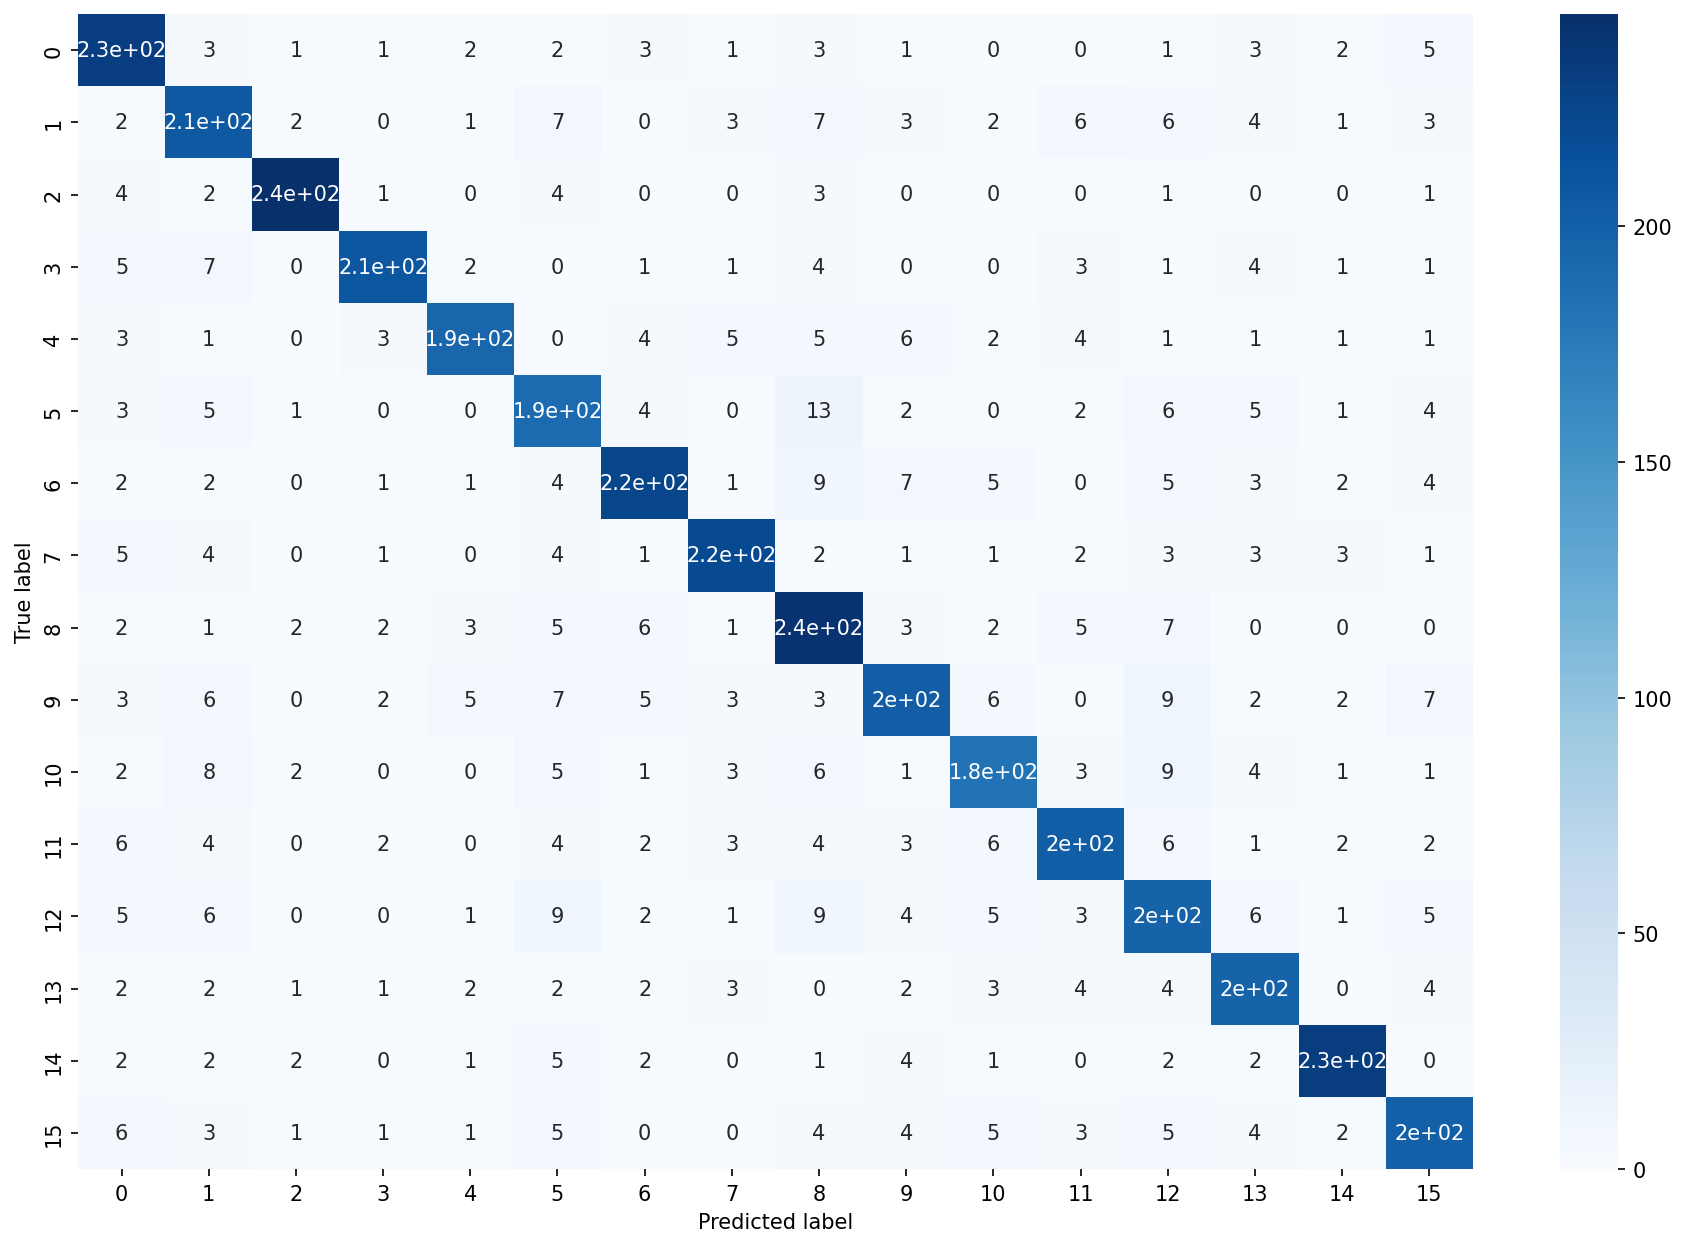

In [10]:
# sklearn.metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)
# plt.title("Confusion Matrix")
# plt.show()

cm = sklearn.metrics.confusion_matrix(Y_test, Y_pred)
figure = plt.figure(figsize=(15, 10), dpi=150)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()